In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
cuDNN version: 91002


In [2]:
import onnxruntime

print(onnxruntime.__version__)
print(onnxruntime.get_device())

1.22.0
GPU


<br><br>

# Image Classification with ResNet-50 and ONNX Runtime GPU

This notebook demonstrates how to:
1. Export a pre-trained ResNet-50 model to ONNX format
2. Run the model on images using ONNX Runtime with GPU acceleration
3. Visualize classification results

<br>

## 1. Export ResNet-50 model to ONNX format

In [3]:
import torch
import torchvision

# Define model input dimensions
model_width = 224
model_height = 224

# Load pretrained ResNet-50 model
model = torchvision.models.resnet50(pretrained=True)
model.eval()

# Create dummy input - standard input size for ResNet-50
dummy_input = torch.randn(1, 3, model_height, model_width)

# Export the model to ONNX format
torch.onnx.export(
    model, 
    dummy_input, 
    "models/resnet50.onnx",
    opset_version=17,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

print(f"ResNet-50 model exported to models/resnet50.onnx with input size {model_width}x{model_height}")

/home/omer/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/omer/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_5642/1804730035.py:16: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and sha

ResNet-50 model exported to models/resnet50.onnx with input size 224x224


<br>

## 2. Run ResNet-50 model on images with ONNX Runtime GPU

In [4]:
import onnxruntime as ort
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt

# Check available providers
print("Available ONNX Runtime providers:", ort.get_available_providers())
print("CUDA provider available:", 'CUDAExecutionProvider' in ort.get_available_providers())

# Load pretrained ResNet-50 model
session = ort.InferenceSession("models/resnet50.onnx", providers=['CUDAExecutionProvider'])
print("Session providers:", session.get_providers())

# Get input details
input_name = session.get_inputs()[0].name
print(f"Input name: {input_name}")

# Load ImageNet class labels
with open("resources/imagenet_labels.json") as f:
    class_idx = json.load(f)

print(f"Loaded {len(class_idx)} ImageNet classes")
print(f"Using model input dimensions: {model_width}x{model_height}")

Available ONNX Runtime providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
CUDA provider available: True
Session providers: ['CUDAExecutionProvider', 'CPUExecutionProvider']
Input name: input
Loaded 1000 ImageNet classes
Using model input dimensions: 224x224


In [5]:
def preprocess_image(image_path, target_size=(model_width, model_height)):
    """Preprocess image for ResNet-50"""
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize image
    img = cv2.resize(img, target_size)
    
    # Convert to float and normalize to [0, 1]
    img = img.astype(np.float32) / 255.0
    
    # Normalize using ImageNet mean and std
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img = (img - mean) / std
    
    # Convert HWC to CHW (channels first)
    img = np.transpose(img, (2, 0, 1))
    
    # Add batch dimension
    img = np.expand_dims(img, 0)
    
    return img

def classify_image(image_path, top_k=5):
    """Classify an image and return top-k predictions"""
    # Preprocess the image
    input_tensor = preprocess_image(image_path)
    
    # Run inference
    outputs = session.run(None, {input_name: input_tensor})
    
    # Process the output
    logits = outputs[0][0]
    
    # Apply softmax to get probabilities
    probs = np.exp(logits) / np.sum(np.exp(logits))
    
    # Get top-k predictions
    top_indices = probs.argsort()[-top_k:][::-1]
    top_probs = probs[top_indices]
    
    # Convert indices to class labels
    top_labels = [class_idx[str(idx)][1] for idx in top_indices]
    
    return top_indices, top_labels, top_probs


Predictions for resources/test_image_shark.jpg:
Great White Shark: 0.9254
Tiger Shark: 0.0740
Submarine: 0.0001
Grey Whale: 0.0001
Hammerhead: 0.0001

Predictions for resources/test_image_cat.jpg:
Egyptian Cat: 0.3434
Tabby: 0.1251
Lynx: 0.0822
Siamese Cat: 0.0657
Tiger Cat: 0.0489


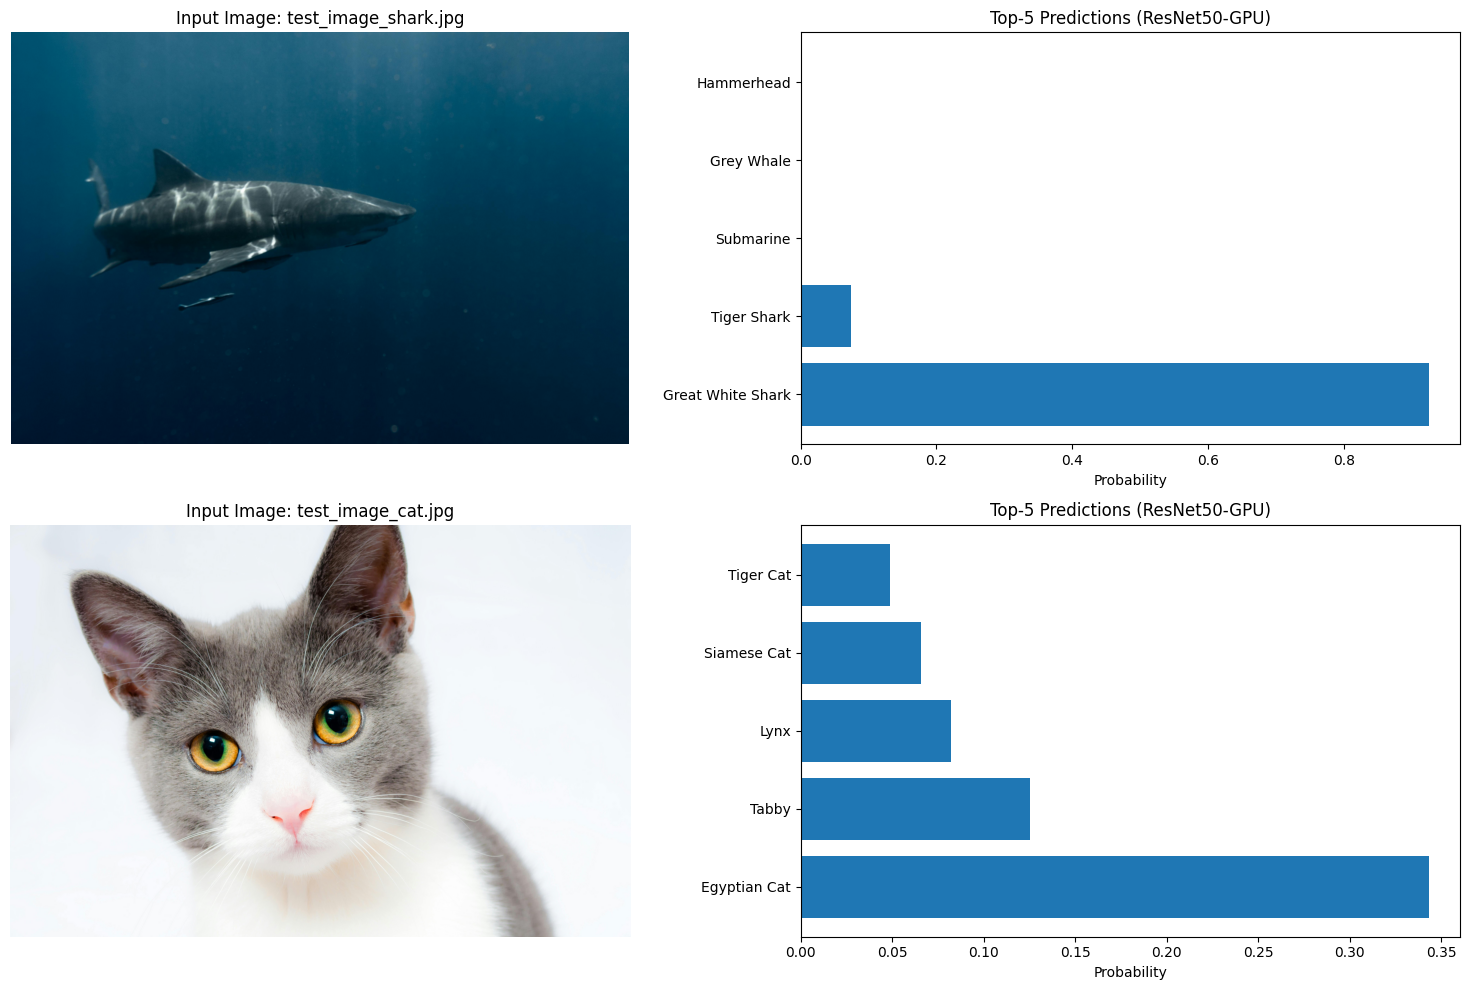

In [6]:
# Classify example images
image_paths = ["resources/test_image_shark.jpg","resources/test_image_cat.jpg"]
device_str = "GPU" if 'CUDAExecutionProvider' in session.get_providers() else "CPU"

plt.figure(figsize=(15, 10))

for i, image_path in enumerate(image_paths):
    # Load and show the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get predictions
    top_indices, top_labels, top_probs = classify_image(image_path, top_k=5)
    
    # Create a subplot
    plt.subplot(len(image_paths), 2, i*2+1)
    plt.imshow(img)
    plt.title(f"Input Image: {image_path.split('/')[-1]}")
    plt.axis('off')
    
    # Create a bar chart for the predictions
    plt.subplot(len(image_paths), 2, i*2+2)
    y_pos = np.arange(len(top_labels))
    plt.barh(y_pos, top_probs, align='center')
    plt.yticks(y_pos, [label.replace('_', ' ').title() for label in top_labels])
    plt.xlabel('Probability')
    plt.title(f"Top-5 Predictions (ResNet50-{device_str})")
    
    # Print results
    print(f"\nPredictions for {image_path}:")
    for label, prob in zip(top_labels, top_probs):
        print(f"{label.replace('_', ' ').title()}: {prob:.4f}")

plt.tight_layout()
plt.show()

